In [21]:
import pandas as pd
import numpy as np
import yfinance as yf

In [22]:
# currency pairs
major_pairs = [
    "EUR/USD", "USD/JPY", "GBP/USD", "USD/CHF",
    "AUD/USD", "USD/CAD", "NZD/USD"
]
minor_pairs = [
    "EUR/GBP", "EUR/CHF", "EUR/AUD", "EUR/CAD", "EUR/NZD", "EUR/JPY",
    "GBP/JPY", "GBP/AUD", "GBP/CAD", "GBP/NZD", "GBP/CHF",
    "AUD/JPY", "AUD/CAD", "AUD/CHF", "AUD/NZD",
    "NZD/JPY", "NZD/CAD", "NZD/CHF",
    "CAD/JPY", "CAD/CHF",
    "CHF/JPY",
    "USD/KRW", "EUR/KRW", "GBP/KRW", "AUD/KRW", "CAD/KRW", 
    "CHF/KRW", "NZD/KRW", "JPY/KRW"
]
exotic_pairs = [
    "USD/HKD", "USD/ZAR", "USD/THB",
    "USD/MXN", "USD/DKK", "USD/NOK", "USD/SEK", "USD/PLN", "USD/CZK",
    "EUR/ZAR", "EUR/NOK", "EUR/SEK", "EUR/DKK", "EUR/HUF", "EUR/PLN",
    "GBP/ZAR",
    "AUD/ZAR",
    "CHF/ZAR"
]

In [23]:
# format currency pairs for data fetching
def format_pairs(pair_list):
    return [f.replace('/', '') + '=X' for f in pair_list]

forex_pairs = format_pairs(major_pairs) + format_pairs(minor_pairs) + format_pairs(exotic_pairs)

# forex_pairs = format_pairs(minor_pairs)


# fetch data function
def fetch_data(pairs, start_date, end_date):
    
    forex_dict = {}

    for pair in pairs:
        ticker = yf.Ticker(pair)
        hist = ticker.history(start=start_date, end=end_date, interval='1d')
        forex_dict[pair] = hist

    return forex_dict


# fetching data from Jan 2014 to Jan 2024
start_date = "2015-01-01"
end_date = "2020-01-01"
forex_data = fetch_data(forex_pairs, start_date, end_date)
SPY_data = yf.download("SPY", start=start_date, end=end_date)
SPY_closing_price = SPY_data['Close']
print(SPY_closing_price)


[*********************100%***********************]  1 of 1 completed
Date
2015-01-02    205.429993
2015-01-05    201.720001
2015-01-06    199.820007
2015-01-07    202.309998
2015-01-08    205.899994
                 ...    
2019-12-24    321.230011
2019-12-26    322.940002
2019-12-27    322.859985
2019-12-30    321.079987
2019-12-31    321.859985
Name: Close, Length: 1258, dtype: float64


In [24]:
# data preprocessing
closing_prices = pd.DataFrame()

for pair, data in forex_data.items():
    closing_prices[pair] = data['Close']
    
closing_prices.dropna(inplace = True, axis=0)

In [49]:
# util functions
def calculate_momentum(prices, lookback_period):
    # shift the prices to ensure current days price not used
    shifted_prices = prices.shift(1)
    return (shifted_prices - shifted_prices.shift(lookback_period)) / shifted_prices.shift(lookback_period)


def rank_and_select_pairs(momentum_df):
    ranked_pairs = momentum_df.rank(axis=1)
    max_ranks = momentum_df.shape[1]
#     long_positions = (ranked_pairs >= 3) & (ranked_pairs <=6) # bottom 5 to 10
#     short_positions = (ranked_pairs >= (int(max_ranks)-7)) & (ranked_pairs <= (int(max_ranks)-2)) # top 5 to 10
   
    short_positions = (ranked_pairs >= (int(max_ranks)-2)) # top 5
    long_positions = (ranked_pairs <= 3) # bottom 5

    return long_positions, short_positions

def calculate_return(long_positions_df,short_positions_df, prices_pct):
    long = prices_pct.loc[:,long_positions_df.iloc[0]]
    short = - prices_pct.loc[:,short_positions_df.iloc[0]]
    merged_df = pd.concat([long[1:], short[1:]], axis=1) # return computation starts from day x + 1 (day x is the repositioning day, where momemtum and ranking is based on day [x-lookback, x-1])
    rtn = pd.DataFrame(merged_df.mean(axis=1), columns=['mean daily ret'])
    return rtn

def evaluate_strategy(rtn_df, SPY_rtn):
    mean_return = rtn_df.values.mean()
    risk_free_rate = 0.02 # 2% annum interest 

    ## Cum Returns ##
    cumulative_rtn = (1 + rtn_df).cumprod() - 1
    

    ## Sharpe Ratio ##
    sharpe_ratio = (mean_return -risk_free_rate/252) / rtn_df.values.std() * np.sqrt(252)  # Adjust for trading days

    ## Maximum Equity Drawdown ##
    cumulative_returns = np.cumprod(1 + np.array(rtn_df)) - 1 # array of the cumulative returns through time
    running_max = np.maximum.accumulate(cumulative_returns) # running max value of cum returns. 
    drawdown = cumulative_returns - running_max # 
    max_drawdown = np.min(drawdown) # the minimal drawdonw corresponds to the Maximum equity drawdown

    ## Sortino Ratio
    downside_returns = np.minimum(0, rtn_df - mean_return)
    downside_deviation = downside_returns.values.std()
    if downside_deviation == 0:
        return None
    sortino_ratio = (mean_return - risk_free_rate/252) / downside_deviation * np.sqrt(252)

    ## ALPHA and BETA calulations ##
    SPY_length = len(SPY_rtn)
    RTN_length = len(rtn_df)
    diff = SPY_length-RTN_length
    if diff>0:
        SPY_rtn = SPY_rtn[diff:]
    else:
        rtn_df = rtn_df[abs(diff):] 

    SPY_rtn = SPY_rtn.values
    rtn_df = rtn_df['mean daily ret'].values
    print(SPY_rtn)
    print(rtn_df)
    print(len(rtn_df))
    cov_ = np.cov(SPY_rtn, rtn_df)
    cov_ = cov_[0,1]
    var_ = SPY_rtn.std()**2
    cumulative_rtn_SPY = (1+SPY_rtn).cumprod() -1
    beta = cov_/var_
    alpha = cumulative_rtn['mean daily ret'].iloc[-1] - beta*cumulative_rtn_SPY[-1]

    ## Success Percentage ##
    positive_values_count = (rtn_df > 0).sum().sum()
    Success_rate = positive_values_count/len(rtn_df)



    return cumulative_rtn, sharpe_ratio, max_drawdown, sortino_ratio, alpha, beta, Success_rate

In [50]:
# backtest funcion
def backtest_strategy(prices, lookback_period, holding_period, SPY_closing_price):

    momentum = calculate_momentum(prices, lookback_period)
    rtn_frames = pd.DataFrame()

    for start in range(lookback_period + 1, len(prices) - holding_period, holding_period):
        
        period_momentum = momentum.iloc[start:start + holding_period]

        long_positions, short_positions = rank_and_select_pairs(period_momentum.iloc[0].to_frame().transpose())
        
        rtn_pct = calculate_return(long_positions, short_positions,
                               prices.pct_change().iloc[start:start + holding_period])

        rtn_frames = pd.concat([rtn_frames, rtn_pct])
    
    SPY_rtn = SPY_closing_price.pct_change()
    SPY_rtn = SPY_rtn[lookback_period:]
    #print(len(SPY_rtn))

    return evaluate_strategy(rtn_frames, SPY_rtn)

In [51]:
# LOOKBACK and HOLDING periods
LOOKBACK_PERIOD = 21  # Days
HOLDING_PERIOD = 21  # Days

# run backtest
cumulative_rtn, sharpe_ratio, max_drawdown, sortino_ratio, alpha, beta, Success_rate = backtest_strategy(closing_prices, LOOKBACK_PERIOD, HOLDING_PERIOD, SPY_closing_price)

print("Short Top 3, Long Bottom 3")
print(f"Return: {cumulative_rtn.iloc[-1, 0]:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Equity Drawdown: {max_drawdown:.2%}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Beta: {beta:.2f}")
print(f"Alpha: {alpha:.2f}")
print(f"Success rate: {Success_rate:.2%}")

[ 0.00228967  0.01219984 -0.00873953 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 1.12953377e-02  6.98527172e-03 -4.88841031e-03 ...  3.37076947e-03
  6.39724932e-05 -5.96790283e-03]
1200
Short Top 3, Long Bottom 3
Return: 26.32%
Sharpe Ratio: 0.38
Maximum Equity Drawdown: -11.20%
Sortino Ratio: 0.62
Beta: 0.02
Alpha: 0.25
Success rate: 50.75%


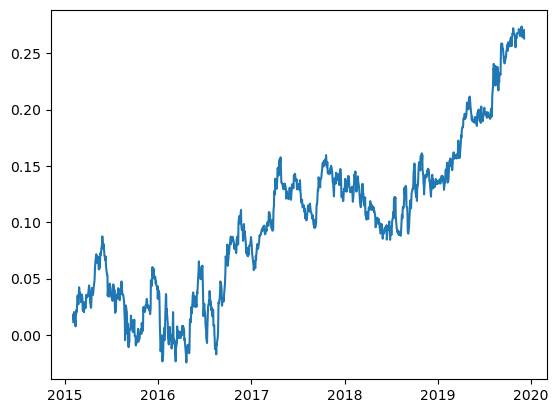

In [52]:
import matplotlib.pyplot as plt
plt.plot(cumulative_rtn)

##### strat 1 - long top 5, short bottom 5

In [62]:
# strat 1 - long top 5%, short bottom 5%
from tqdm.notebook import tqdm 

period_values = [5, 10, 15, 21, 21*2, 21*3, 21*4, 21*6]

# initialize matrices
cumulative_returns_matrix = pd.DataFrame(index=period_values, columns=period_values)
sharpe_ratios_matrix = pd.DataFrame(index=period_values, columns=period_values)
max_eq_drawd_matrix = pd.DataFrame(index=period_values, columns=period_values)
sortino_ratio_matrix = pd.DataFrame(index=period_values, columns=period_values)
alpha_matrix = pd.DataFrame(index=period_values, columns=period_values)
beta_matrix = pd.DataFrame(index=period_values, columns=period_values)
Success_rate_matrix = pd.DataFrame(index=period_values, columns=period_values)

# nested loop
for lookback_period in tqdm(period_values):
    for holding_period in period_values:
        # backtest for current combination
        cumulative_rtn, sharpe_ratio, max_drawdown, sortino_ratio, alpha, beta, Success_rate = backtest_strategy(closing_prices, lookback_period, holding_period, SPY_closing_price)
        
        # 
        cumulative_returns_matrix.loc[lookback_period, holding_period] = cumulative_rtn.iloc[-1, 0]
        sharpe_ratios_matrix.loc[lookback_period, holding_period] = sharpe_ratio
        max_eq_drawd_matrix.loc[lookback_period, holding_period] = max_drawdown 
        sortino_ratio_matrix.loc[lookback_period, holding_period] = sortino_ratio
        alpha_matrix.loc[lookback_period, holding_period] = alpha
        beta_matrix.loc[lookback_period, holding_period] = beta
        Success_rate_matrix.loc[lookback_period, holding_period] = Success_rate

cumulative_returns_matrix = cumulative_returns_matrix.applymap(lambda x: f"{x:.2%}")
sharpe_ratios_matrix = sharpe_ratios_matrix.applymap(lambda x: f"{x:.2f}")
max_eq_drawd_matrix = max_eq_drawd_matrix.applymap(lambda x: f"{x:.2%}")
sortino_ratio_matrix = sortino_ratio_matrix.applymap(lambda x: f"{x:.2f}")
alpha_matrix = alpha_matrix.applymap(lambda x: f"{x:.2f}")
beta_matrix = beta_matrix.applymap(lambda x: f"{x:.2f}")
Success_rate_matrix = Success_rate_matrix.applymap(lambda x: f"{x:.2f}")

  0%|          | 0/8 [00:00<?, ?it/s]

[ 0.00133926 -0.00014329  0.00114652 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 0.0008088  -0.00314765 -0.00078609 ...  0.0004474  -0.00168346
 -0.00103644]
1032
[-0.00238873 -0.01075172  0.00949217 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 0.0008088  -0.00314765 -0.00078609 ...  0.00178924  0.00357849
  0.0015119 ]
1161
[-0.00194859 -0.00561901 -0.01465383 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 0.0008088  -0.00314765 -0.00078609 ...  0.00248223 -0.00024326
 -0.00071473]
1204
[-0.00340619  0.0063135  -0.00410402 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 8.08802152e-04 -3.14764968e-03 -7.86088562e-04 ... -2.94012469e-05
  1.88894561e-03  4.00756537e-03]
1220
[ 0.00961681  0.00411641  0.00157309 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 0.0008088  -0.00314765 -0.00078609 ...  0.00011713  0.00265853
  0.00266673]
1230
[ 0.00924356 -0.01257492  0.01238406 ... -0.00024778 -0.00551322
  0.0024293 ]
[ 0.0008088  -0.00314765 -0.00078609 ... -0.00067919 -0.0011486
 -0.00211482]
1240

In [63]:
cumulative_returns_matrix

,5,10,15,21,42,63,84,126
5,0.24%,20.74%,-4.30%,29.54%,9.54%,-4.92%,7.95%,19.62%
10,17.39%,-0.21%,2.79%,3.05%,-12.48%,-12.24%,10.91%,-10.09%
15,19.29%,29.19%,32.22%,-3.70%,14.36%,26.46%,23.17%,10.77%
21,25.69%,19.81%,3.50%,26.32%,24.68%,21.02%,25.71%,7.75%
42,6.64%,1.44%,6.09%,8.51%,23.53%,18.43%,15.00%,-11.26%
63,12.34%,21.23%,9.56%,11.68%,17.95%,4.19%,14.18%,4.15%
84,23.91%,21.96%,21.79%,8.02%,10.55%,12.00%,19.87%,20.78%
126,37.42%,33.15%,8.75%,14.84%,5.21%,12.41%,-0.15%,-3.78%


In [64]:
sharpe_ratios_matrix

,5,10,15,21,42,63,84,126
5,-0.18,0.29,-0.30,0.44,0.02,-0.36,-0.02,0.26
10,0.28,-0.21,-0.13,-0.12,-0.51,-0.53,0.05,-0.50
15,0.32,0.47,0.49,-0.32,0.13,0.38,0.30,0.05
21,0.49,0.27,-0.10,0.38,0.34,0.26,0.34,-0.01
42,-0.00,-0.16,-0.04,0.01,0.35,0.24,0.17,-0.49
63,0.16,0.33,0.04,0.09,0.22,-0.09,0.14,-0.07
84,0.46,0.35,0.34,0.01,0.07,0.09,0.27,0.29
126,0.79,0.60,0.04,0.17,-0.05,0.12,-0.20,-0.29


In [65]:
max_eq_drawd_matrix

,5,10,15,21,42,63,84,126
5,-17.82%,-12.62%,-14.76%,-14.14%,-14.89%,-15.31%,-14.73%,-11.29%
10,-8.96%,-20.95%,-11.37%,-11.62%,-20.60%,-16.11%,-18.61%,-21.75%
15,-13.54%,-14.98%,-20.97%,-19.66%,-17.70%,-15.21%,-20.84%,-19.24%
21,-8.36%,-14.85%,-17.69%,-11.20%,-18.19%,-17.13%,-19.06%,-18.46%
42,-11.25%,-15.86%,-15.08%,-13.06%,-10.13%,-11.72%,-8.22%,-20.19%
63,-11.03%,-9.59%,-10.76%,-11.92%,-13.11%,-17.06%,-10.71%,-20.68%
84,-9.96%,-12.70%,-12.58%,-13.24%,-13.48%,-20.16%,-17.78%,-16.41%
126,-8.59%,-9.82%,-17.25%,-20.64%,-16.53%,-14.93%,-16.91%,-13.46%


In [66]:
sortino_ratio_matrix

,5,10,15,21,42,63,84,126
5,-0.31,0.51,-0.49,0.74,0.04,-0.60,-0.03,0.43
10,0.45,-0.34,-0.22,-0.21,-0.87,-0.89,0.09,-0.80
15,0.53,0.79,0.82,-0.54,0.22,0.61,0.49,0.08
21,0.82,0.43,-0.16,0.62,0.56,0.43,0.55,-0.01
42,-0.00,-0.25,-0.07,0.02,0.56,0.40,0.28,-0.78
63,0.26,0.54,0.07,0.14,0.36,-0.15,0.23,-0.11
84,0.76,0.57,0.55,0.01,0.11,0.14,0.43,0.46
126,1.33,0.99,0.06,0.27,-0.08,0.18,-0.31,-0.45


In [67]:
alpha_matrix

,5,10,15,21,42,63,84,126
5,-0.00,0.20,-0.04,0.31,0.07,-0.05,0.09,0.21
10,0.17,0.00,0.04,0.02,-0.13,-0.12,0.11,-0.11
15,0.20,0.29,0.32,-0.04,0.14,0.28,0.24,0.09
21,0.28,0.19,0.03,0.25,0.23,0.19,0.26,0.09
42,0.08,0.01,0.06,0.09,0.22,0.19,0.15,-0.09
63,0.12,0.21,0.08,0.12,0.17,0.05,0.15,0.03
84,0.25,0.19,0.22,0.09,0.10,0.10,0.19,0.21
126,0.38,0.33,0.09,0.15,0.06,0.11,-0.00,-0.04


In [68]:
beta_matrix

,5,10,15,21,42,63,84,126
5,0.01,0.02,-0.00,-0.02,0.05,-0.01,-0.02,-0.02
10,0.01,-0.01,-0.02,0.02,0.00,-0.00,-0.01,0.01
15,-0.01,0.01,-0.00,0.01,0.01,-0.03,-0.02,0.03
21,-0.04,0.02,0.01,0.02,0.03,0.03,0.00,-0.03
42,-0.02,0.00,0.00,-0.00,0.03,-0.01,-0.01,-0.04
63,-0.00,-0.00,0.04,-0.01,0.02,-0.01,-0.01,0.02
84,-0.01,0.04,-0.01,-0.01,0.01,0.05,0.01,-0.01
126,-0.01,-0.00,-0.01,-0.01,-0.01,0.02,-0.00,0.01


In [69]:
Success_rate_matrix

,5,10,15,21,42,63,84,126
5,0.50,0.51,0.50,0.52,0.49,0.50,0.51,0.51
10,0.53,0.51,0.50,0.48,0.47,0.48,0.51,0.49
15,0.51,0.51,0.51,0.50,0.49,0.53,0.51,0.50
21,0.51,0.52,0.51,0.51,0.51,0.52,0.52,0.51
42,0.50,0.50,0.50,0.51,0.52,0.52,0.51,0.50
63,0.52,0.52,0.50,0.52,0.51,0.50,0.50,0.50
84,0.52,0.52,0.52,0.51,0.52,0.51,0.51,0.50
126,0.51,0.51,0.50,0.51,0.50,0.49,0.49,0.49


STRATEGY 2 

In [108]:
period_values = [5, 10, 15, 21, 21*2, 21*3, 21*4, 21*6]

# initialize matrices
cumulative_returns_matrix = pd.DataFrame(index=period_values, columns=period_values)
sharpe_ratios_matrix = pd.DataFrame(index=period_values, columns=period_values)
max_eq_drawd_matrix = pd.DataFrame(index=period_values, columns=period_values)
sortino_ratio_matrix = pd.DataFrame(index=period_values, columns=period_values)

# nested loop
for lookback_period in tqdm(period_values):
    for holding_period in period_values:
        # backtest for current combination
        cumulative_rtn, sharpe_ratio, max_drawdown, sortino_ratio, alpha, beta, Success_rate = backtest_strategy(closing_prices, lookback_period, holding_period)
        
        # 
        cumulative_returns_matrix.loc[lookback_period, holding_period] = cumulative_rtn.iloc[-1, 0]
        sharpe_ratios_matrix.loc[lookback_period, holding_period] = sharpe_ratio
        max_eq_drawd_matrix.loc[lookback_period, holding_period] = max_drawdown
        sortino_ratio_matrix.loc[lookback_period, holding_period] = sortino_ratio

cumulative_returns_matrix = cumulative_returns_matrix.applymap(lambda x: f"{x:.2%}")
sharpe_ratios_matrix = sharpe_ratios_matrix.applymap(lambda x: f"{x:.2f}")
max_eq_drawd_matrix = max_eq_drawd_matrix.applymap(lambda x: f"{x:.2%}")
sortino_ratio_matrix = sortino_ratio_matrix.applymap(lambda x: f"{x:.2f}")

  0%|          | 0/8 [00:00<?, ?it/s]

In [109]:
cumulative_returns_matrix

,5,10,15,21,42,63,84,126
5,2.59%,2.16%,40.37%,-2.20%,13.78%,19.82%,-11.33%,4.22%
10,11.87%,41.94%,11.15%,2.03%,25.84%,29.82%,-1.85%,-9.91%
15,15.98%,-15.90%,14.60%,33.56%,35.37%,62.69%,-2.69%,10.19%
21,46.95%,42.56%,50.47%,64.64%,48.24%,55.35%,-8.34%,-8.33%
42,2.03%,18.73%,37.81%,36.04%,5.36%,17.27%,15.68%,-2.16%
63,0.97%,9.72%,29.72%,37.44%,29.71%,12.65%,31.80%,-8.11%
84,48.22%,43.28%,25.53%,46.08%,22.84%,9.61%,11.42%,0.02%
126,72.16%,42.36%,50.29%,30.64%,9.55%,-3.70%,12.03%,-9.71%


In [110]:
sharpe_ratios_matrix

,5,10,15,21,42,63,84,126
5,-0.15,-0.17,0.22,-0.24,-0.05,0.01,-0.37,-0.19
10,-0.04,0.25,-0.06,-0.18,0.08,0.11,-0.23,-0.36
15,0.02,-0.43,-0.03,0.16,0.17,0.41,-0.26,-0.09
21,0.37,0.27,0.32,0.43,0.28,0.35,-0.32,-0.32
42,-0.16,0.03,0.21,0.18,-0.12,-0.01,-0.02,-0.26
63,-0.17,-0.07,0.13,0.20,0.12,-0.06,0.14,-0.32
84,0.37,0.27,0.10,0.28,0.06,-0.09,-0.06,-0.19
126,0.63,0.27,0.33,0.14,-0.08,-0.26,-0.06,-0.35


In [111]:
max_eq_drawd_matrix

,5,10,15,21,42,63,84,126
5,-34.60%,-30.39%,-19.73%,-17.84%,-17.79%,-17.25%,-23.06%,-23.17%
10,-19.67%,-22.66%,-23.56%,-20.21%,-14.71%,-18.41%,-25.15%,-23.42%
15,-25.42%,-33.27%,-28.11%,-19.41%,-19.04%,-12.90%,-21.75%,-16.70%
21,-13.23%,-19.84%,-13.21%,-14.80%,-15.59%,-13.29%,-17.11%,-17.25%
42,-34.46%,-26.33%,-20.30%,-17.22%,-28.24%,-18.47%,-26.93%,-19.48%
63,-25.76%,-20.97%,-26.18%,-17.88%,-14.15%,-31.03%,-28.06%,-30.36%
84,-17.13%,-14.76%,-20.29%,-26.08%,-37.68%,-27.30%,-32.38%,-28.21%
126,-19.33%,-30.43%,-20.79%,-24.96%,-28.27%,-39.30%,-30.19%,-38.62%


In [112]:
sortino_ratio_matrix

,5,10,15,21,42,63,84,126
5,-0.26,-0.28,0.40,-0.39,-0.07,0.02,-0.57,-0.29
10,-0.06,0.40,-0.10,-0.29,0.13,0.19,-0.35,-0.59
15,0.03,-0.71,-0.05,0.27,0.29,0.71,-0.42,-0.15
21,0.62,0.45,0.55,0.72,0.47,0.59,-0.52,-0.51
42,-0.27,0.05,0.36,0.31,-0.21,-0.01,-0.03,-0.43
63,-0.29,-0.11,0.23,0.34,0.21,-0.10,0.23,-0.52
84,0.63,0.45,0.16,0.47,0.10,-0.14,-0.11,-0.32
126,1.08,0.46,0.55,0.24,-0.14,-0.43,-0.10,-0.58


##### strat 3 - short top 3, long bottom 3

In [14]:
period_values = [5, 10, 15, 21, 21*2, 21*3, 21*4, 21*6]

# initialize matrices
cumulative_returns_matrix = pd.DataFrame(index=period_values, columns=period_values)
sharpe_ratios_matrix = pd.DataFrame(index=period_values, columns=period_values)
max_eq_drawd_matrix = pd.DataFrame(index=period_values, columns=period_values)
sortino_ratio_matrix = pd.DataFrame(index=period_values, columns=period_values)

# nested loop
for lookback_period in tqdm(period_values):
    for holding_period in period_values:
        # backtest for current combination
        cumulative_rtn, sharpe_ratio, max_drawdown, sortino_ratio, alpha, beta, Success_rate = backtest_strategy(closing_prices, lookback_period, holding_period)
        
        # 
        cumulative_returns_matrix.loc[lookback_period, holding_period] = cumulative_rtn.iloc[-1, 0]
        sharpe_ratios_matrix.loc[lookback_period, holding_period] = sharpe_ratio
        max_eq_drawd_matrix.loc[lookback_period, holding_period]= max_drawdown
        sortino_ratio_matrix.loc[lookback_period, holding_period] = sortino_ratio

cumulative_returns_matrix = cumulative_returns_matrix.applymap(lambda x: f"{x:.2%}")
sharpe_ratios_matrix = sharpe_ratios_matrix.applymap(lambda x: f"{x:.2f}")
max_eq_drawd_matrix = max_eq_drawd_matrix.applymap(lambda x: f"{x:.2%}")
sortino_ratio_matrix = sortino_ratio_matrix.applymap(lambda x: f"{x:.2f}")

NameError: name 'tqdm' is not defined

In [ ]:
cumulative_returns_matrix

,5,10,15,21,42,63,84,126
5,2.59%,2.16%,40.37%,-2.20%,13.78%,19.82%,-11.33%,4.22%
10,11.87%,41.94%,11.15%,2.03%,25.84%,29.82%,-1.85%,-9.91%
15,15.98%,-15.90%,14.60%,33.56%,35.37%,62.69%,-2.69%,10.19%
21,46.95%,42.56%,50.47%,64.64%,48.24%,55.35%,-8.34%,-8.33%
42,2.03%,18.73%,37.81%,36.04%,5.36%,17.27%,15.68%,-2.16%
63,0.97%,9.72%,29.72%,37.44%,29.71%,12.65%,31.80%,-8.11%
84,48.22%,43.28%,25.53%,46.08%,22.84%,9.61%,11.42%,0.02%
126,72.16%,42.36%,50.29%,30.64%,9.55%,-3.70%,12.03%,-9.71%


In [ ]:
sharpe_ratios_matrix

,5,10,15,21,42,63,84,126
5,-0.15,-0.17,0.22,-0.24,-0.05,0.01,-0.37,-0.19
10,-0.04,0.25,-0.06,-0.18,0.08,0.11,-0.23,-0.36
15,0.02,-0.43,-0.03,0.16,0.17,0.41,-0.26,-0.09
21,0.37,0.27,0.32,0.43,0.28,0.35,-0.32,-0.32
42,-0.16,0.03,0.21,0.18,-0.12,-0.01,-0.02,-0.26
63,-0.17,-0.07,0.13,0.20,0.12,-0.06,0.14,-0.32
84,0.37,0.27,0.10,0.28,0.06,-0.09,-0.06,-0.19
126,0.63,0.27,0.33,0.14,-0.08,-0.26,-0.06,-0.35


In [15]:
max_eq_drawd_matrix

,5,10,15,21,42,63,84,126
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
sortino_ratio_matrix

,5,10,15,21,42,63,84,126
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### strat 4 - short top 3-6, long bottom 3-6

In [118]:
period_values = [5, 10, 15, 21, 21*2, 21*3, 21*4, 21*6]

# initialize matrices
cumulative_returns_matrix = pd.DataFrame(index=period_values, columns=period_values)
sharpe_ratios_matrix = pd.DataFrame(index=period_values, columns=period_values)
max_eq_drawd_matrix = pd.DataFrame(index=period_values, columns=period_values)
sortino_ratio_matrix = pd.DataFrame(index=period_values, columns=period_values)

# nested loop
for lookback_period in tqdm(period_values):
    for holding_period in period_values:
        # backtest for current combination
        cumulative_rtn, sharpe_ratio, max_drawdown, sortino_ratio, alpha, beta, Success_rate = backtest_strategy(closing_prices, lookback_period, holding_period)
        
        # 
        cumulative_returns_matrix.loc[lookback_period, holding_period] = cumulative_rtn.iloc[-1, 0]
        sharpe_ratios_matrix.loc[lookback_period, holding_period] = sharpe_ratio
        max_eq_drawd_matrix.loc[lookback_period, holding_period]= max_drawdown
        sortino_ratio_matrix.loc[lookback_period, holding_period] = sortino_ratio

cumulative_returns_matrix = cumulative_returns_matrix.applymap(lambda x: f"{x:.2%}")
sharpe_ratios_matrix = sharpe_ratios_matrix.applymap(lambda x: f"{x:.2f}")
max_eq_drawd_matrix = max_eq_drawd_matrix.applymap(lambda x: f"{x:.2%}")
sortino_ratio_matrix = sortino_ratio_matrix.applymap(lambda x: f"{x:.2f}")

  0%|          | 0/8 [00:00<?, ?it/s]

In [119]:
cumulative_returns_matrix

,5,10,15,21,42,63,84,126
5,2.59%,2.16%,40.37%,-2.20%,13.78%,19.82%,-11.33%,4.22%
10,11.87%,41.94%,11.15%,2.03%,25.84%,29.82%,-1.85%,-9.91%
15,15.98%,-15.90%,14.60%,33.56%,35.37%,62.69%,-2.69%,10.19%
21,46.95%,42.56%,50.47%,64.64%,48.24%,55.35%,-8.34%,-8.33%
42,2.03%,18.73%,37.81%,36.04%,5.36%,17.27%,15.68%,-2.16%
63,0.97%,9.72%,29.72%,37.44%,29.71%,12.65%,31.80%,-8.11%
84,48.22%,43.28%,25.53%,46.08%,22.84%,9.61%,11.42%,0.02%
126,72.16%,42.36%,50.29%,30.64%,9.55%,-3.70%,12.03%,-9.71%


In [120]:
sharpe_ratios_matrix

,5,10,15,21,42,63,84,126
5,-0.15,-0.17,0.22,-0.24,-0.05,0.01,-0.37,-0.19
10,-0.04,0.25,-0.06,-0.18,0.08,0.11,-0.23,-0.36
15,0.02,-0.43,-0.03,0.16,0.17,0.41,-0.26,-0.09
21,0.37,0.27,0.32,0.43,0.28,0.35,-0.32,-0.32
42,-0.16,0.03,0.21,0.18,-0.12,-0.01,-0.02,-0.26
63,-0.17,-0.07,0.13,0.20,0.12,-0.06,0.14,-0.32
84,0.37,0.27,0.10,0.28,0.06,-0.09,-0.06,-0.19
126,0.63,0.27,0.33,0.14,-0.08,-0.26,-0.06,-0.35


In [121]:
max_eq_drawd_matrix

,5,10,15,21,42,63,84,126
5,-34.60%,-30.39%,-19.73%,-17.84%,-17.79%,-17.25%,-23.06%,-23.17%
10,-19.67%,-22.66%,-23.56%,-20.21%,-14.71%,-18.41%,-25.15%,-23.42%
15,-25.42%,-33.27%,-28.11%,-19.41%,-19.04%,-12.90%,-21.75%,-16.70%
21,-13.23%,-19.84%,-13.21%,-14.80%,-15.59%,-13.29%,-17.11%,-17.25%
42,-34.46%,-26.33%,-20.30%,-17.22%,-28.24%,-18.47%,-26.93%,-19.48%
63,-25.76%,-20.97%,-26.18%,-17.88%,-14.15%,-31.03%,-28.06%,-30.36%
84,-17.13%,-14.76%,-20.29%,-26.08%,-37.68%,-27.30%,-32.38%,-28.21%
126,-19.33%,-30.43%,-20.79%,-24.96%,-28.27%,-39.30%,-30.19%,-38.62%


In [122]:
sortino_ratio_matrix

,5,10,15,21,42,63,84,126
5,-0.26,-0.28,0.40,-0.39,-0.07,0.02,-0.57,-0.29
10,-0.06,0.40,-0.10,-0.29,0.13,0.19,-0.35,-0.59
15,0.03,-0.71,-0.05,0.27,0.29,0.71,-0.42,-0.15
21,0.62,0.45,0.55,0.72,0.47,0.59,-0.52,-0.51
42,-0.27,0.05,0.36,0.31,-0.21,-0.01,-0.03,-0.43
63,-0.29,-0.11,0.23,0.34,0.21,-0.10,0.23,-0.52
84,0.63,0.45,0.16,0.47,0.10,-0.14,-0.11,-0.32
126,1.08,0.46,0.55,0.24,-0.14,-0.43,-0.10,-0.58
